In [2]:
import pandas as pd

# Read the data
df = pd.read_csv('./data/news/all_articles_combined_machine_annotation.csv')
df_cov = pd.read_csv('./data/crime_pop_freq.csv')
df_cov = df_cov.fillna(0)

In [3]:
# Define valid US state codes (50 states + DC)
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 
                'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME',
                'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH',
                'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI',
                'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# Filter to only valid US states
df = df[df['location'].isin(states)]

df_frequency = df.groupby(['location', 'date']).size().reset_index(name='frequency')

print(f"Original data shape: {df.shape}")
print(f"Grouped data shape: {df_frequency.shape}")
print("\nFirst 10 rows:")
print(df_frequency.head(10))
print("\nSummary statistics:")
print(df_frequency['frequency'].describe())


Original data shape: (7237, 14)
Grouped data shape: (1365, 3)

First 10 rows:
  location     date  frequency
0       AK  2022/07          1
1       AK  2023/01          1
2       AK  2024/12          1
3       AK  2025/08          1
4       AL  2022/03          1
5       AL  2022/04          1
6       AL  2022/05         21
7       AL  2022/06          1
8       AL  2022/07          3
9       AL  2022/08          1

Summary statistics:
count    1365.000000
mean        5.301832
std        10.411041
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       181.000000
Name: frequency, dtype: float64


In [4]:
# Convert date to datetime to find full range
df_frequency['date_dt'] = pd.to_datetime(df_frequency['date'], format='%Y/%m')

# Get min and max dates
min_date = df_frequency['date_dt'].min()
max_date = df_frequency['date_dt'].max()

# Create complete date range (all months from min to max)
all_dates = pd.date_range(start=min_date, end=max_date, freq='MS')
all_dates_str = all_dates.strftime('%Y/%m').tolist()

# Create complete grid: all locations × all dates
complete_grid = pd.MultiIndex.from_product(
    [states, all_dates_str],
    names=['location', 'date']
).to_frame(index=False)

# Merge with actual frequency data
df_frequency_filled = complete_grid.merge(
    df_frequency[['location', 'date', 'frequency']],
    on=['location', 'date'],
    how='left'
)

# Fill NaN with 0
df_frequency_filled['frequency'] = df_frequency_filled['frequency'].fillna(0).astype(int)


In [5]:
# Create g column (first treatment time group)
# DC treated in 2025/08, IL treated in 2025/09, others never treated (0)
df_frequency_filled['g'] = 0
df_frequency_filled.loc[df_frequency_filled['location'] == 'DC', 'g'] = '2025/08'
df_frequency_filled.loc[df_frequency_filled['location'] == 'IL', 'g'] = '2025/09'

# Create d column (binary treatment indicator)
# 1 if location is treated AND date >= treatment date, else 0
df_frequency_filled['d'] = 0

# DC treated from 2025/08 onwards
df_frequency_filled.loc[
    (df_frequency_filled['location'] == 'DC') & 
    (df_frequency_filled['date'] >= '2025/08'), 
    'd'
] = 1

# IL treated from 2025/09 onwards
df_frequency_filled.loc[
    (df_frequency_filled['location'] == 'IL') & 
    (df_frequency_filled['date'] >= '2025/09'), 
    'd'
] = 1


/var/folders/8g/6g1j06xd7ms8hzz2_27br4vh0000gn/T/ipykernel_41833/3150635433.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025/08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_frequency_filled.loc[df_frequency_filled['location'] == 'DC', 'g'] = '2025/08'


/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:65: UserWarning: Not returning pre-test Wald statistic due to singular covariance matrix
  warnings.warn("Not returning pre-test Wald statistic due to singular covariance matrix", UserWarning)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:174: UserWarning: Simultaneous confidence band is smaller than pointwise one. Reporting pointwise confidence intervals instead.
  warnings.warn(
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:174: UserWarning: Simultaneous confidence band is smaller than pointwise one. Reporting pointwise confidence intervals instead.
  warnings.warn(
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didcont/estimation/process_attgt.py:1

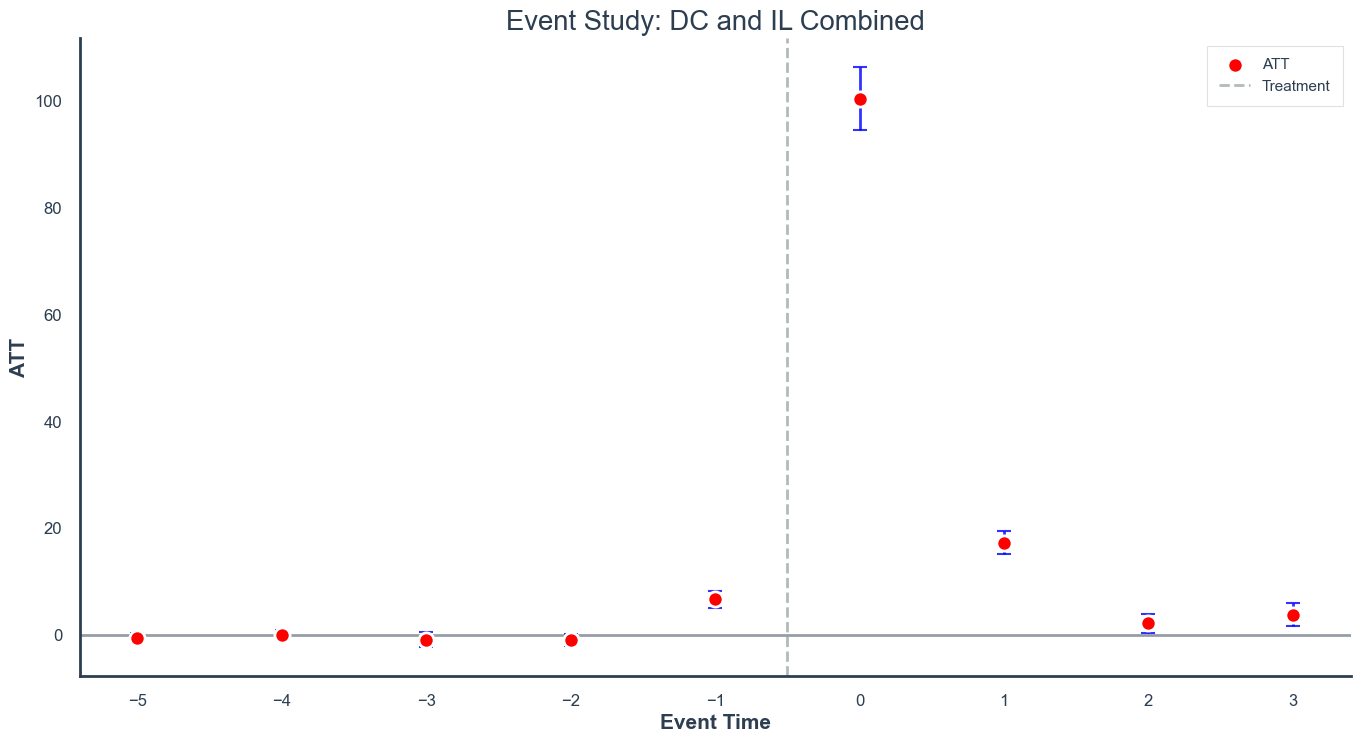

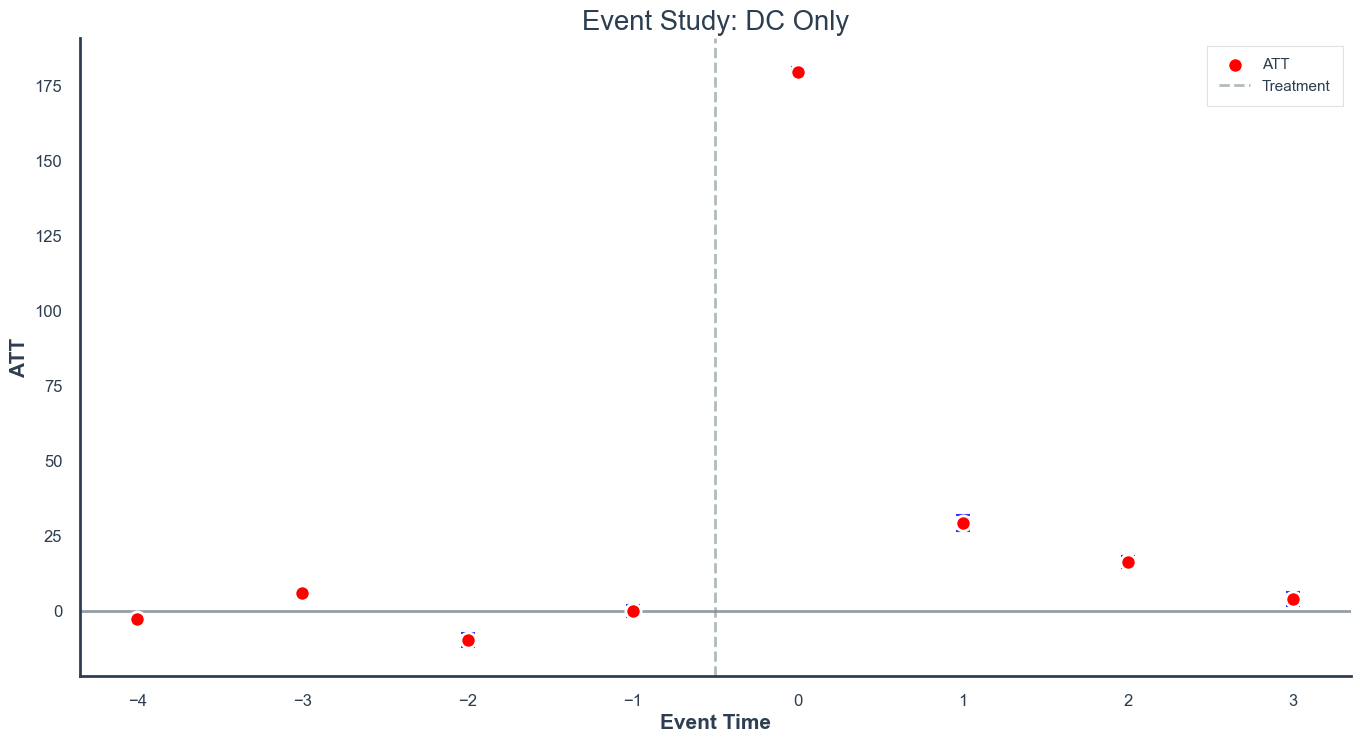

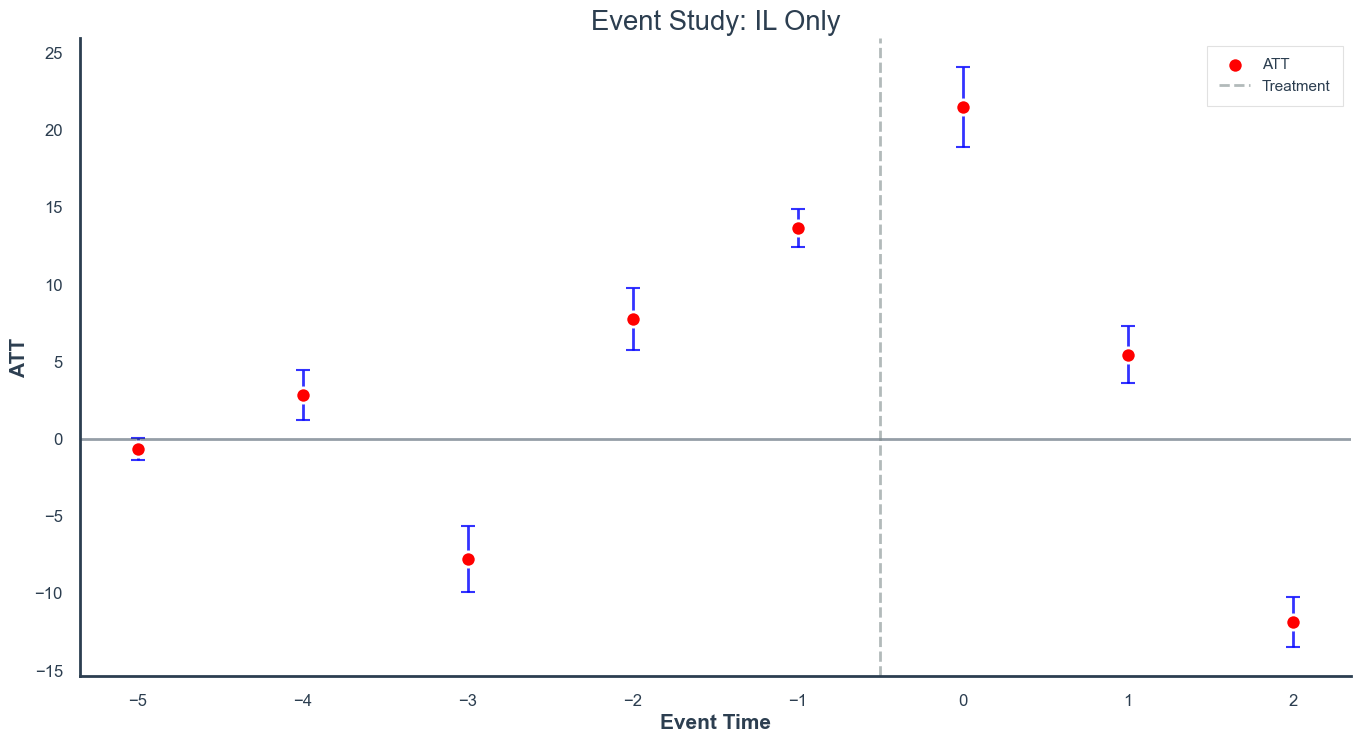

In [ ]:
# Imports
from moderndid.didcont import cont_did
from moderndid.didcont.plots import plot_cont_did
import matplotlib.pyplot as plt

# Data prep
df_panel = df_frequency_filled.copy()
df_panel['date_dt'] = pd.to_datetime(df_panel['date'], format='%Y/%m')
# Create time_period in YYYYMM format (e.g., 202201 for 2022/01)
df_panel['time_period'] = df_panel['date_dt'].dt.year * 100 + df_panel['date_dt'].dt.month
df_panel['id'] = pd.Categorical(df_panel['location']).codes

# Treatment times in YYYYMM format
dc_treat_time = 202508  # 2025/08
il_treat_time = 202509  # 2025/09

min_treat_time = min(dc_treat_time, il_treat_time)
# Keep data from 5 months before earliest treatment
df_panel = df_panel[df_panel['time_period'] >= (min_treat_time - 5)]

df_panel['G'] = 0
df_panel.loc[df_panel['location'] == 'DC', 'G'] = dc_treat_time
df_panel.loc[df_panel['location'] == 'IL', 'G'] = il_treat_time
df_panel['D'] = 0
df_panel.loc[df_panel['location'] == 'DC', 'D'] = 1
df_panel.loc[df_panel['location'] == 'IL', 'D'] = 1
df_panel['Y'] = df_panel['frequency']

# Model 1: Both DC and IL
cd_both = cont_did(
    yname="Y",
    tname="time_period",
    idname="id",
    dname="D",
    data=df_panel,
    gname="G",
    target_parameter="level",
    aggregation="eventstudy",
    treatment_type="continuous",
    control_group="notyettreated",
    biters=100,
    cband=True,
    num_knots=1,
    degree=3,
)

# Model 2: DC only
df_dc = df_panel[df_panel['location'].isin(['DC'] + [s for s in states if s not in ['DC', 'IL']])].copy()
df_dc = df_dc[df_dc['G'].isin([0, dc_treat_time])]

cd_dc = cont_did(
    yname="Y",
    tname="time_period",
    idname="id",
    dname="D",
    data=df_dc,
    gname="G",
    target_parameter="level",
    aggregation="eventstudy",
    treatment_type="continuous",
    control_group="notyettreated",
    biters=100,
    cband=True,
    num_knots=1,
    degree=3,
)

# Model 3: IL only
df_il = df_panel[df_panel['location'].isin(['IL'] + [s for s in states if s not in ['DC', 'IL']])].copy()
df_il = df_il[df_il['G'].isin([0, il_treat_time])]

cd_il = cont_did(
    yname="Y",
    tname="time_period",
    idname="id",
    dname="D",
    data=df_il,
    gname="G",
    target_parameter="level",
    aggregation="eventstudy",
    treatment_type="continuous",
    control_group="notyettreated",
    biters=100,
    cband=True,
    num_knots=1,
    degree=3,
)

# Plot 1: Both
fig1 = plot_cont_did(cd_both, type='att', show_confidence_bands=True)
plt.title('Event Study: DC and IL Combined')
plt.show()

# Plot 2: DC
fig2 = plot_cont_did(cd_dc, type='att', show_confidence_bands=True)
plt.title('Event Study: DC Only')
plt.show()

# Plot 3: IL
fig3 = plot_cont_did(cd_il, type='att', show_confidence_bands=True)
plt.title('Event Study: IL Only')
plt.show()

          lb          ub method    delta  Mbar
0  92.699824  108.149564   C-LF  DeltaRM   0.5
1  88.894260  111.955128   C-LF  DeltaRM   1.0
2  84.863336  115.986051   C-LF  DeltaRM   1.5
3  80.652559  120.196829   C-LF  DeltaRM   2.0
4  55.166812  145.682575   C-LF  DeltaRM   5.0
5  11.569101  189.280287   C-LF  DeltaRM  10.0


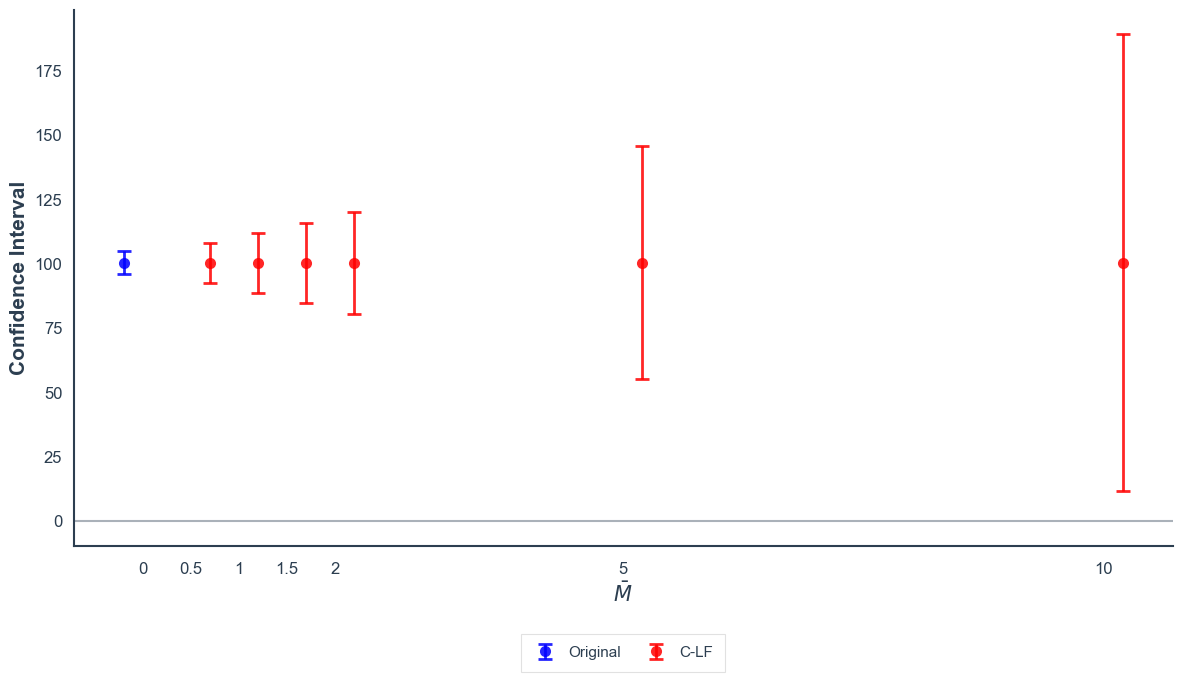

In [7]:
import numpy as np
from moderndid import create_sensitivity_results_rm, construct_original_cs, plot_sensitivity_rm

# Extract event study results from cd_both.event_study (PTEAggteResult object)
event_times = cd_both.event_study.event_times
att_by_event = cd_both.event_study.att_by_event
se_by_event = cd_both.event_study.se_by_event

# Separate pre and post treatment periods
pre_mask = event_times < 0
post_mask = event_times >= 0

# Extract coefficients in order: pre-treatment first, then post-treatment
betahat = np.concatenate([att_by_event[pre_mask], att_by_event[post_mask]])
se_all = np.concatenate([se_by_event[pre_mask], se_by_event[post_mask]])

# Construct variance-covariance matrix from standard errors
sigma = np.diag(se_all ** 2)

num_pre_periods = int(np.sum(pre_mask))
num_post_periods = int(np.sum(post_mask))

# Construct original confidence intervals
original_ci = construct_original_cs(
    betahat=betahat,
    sigma=sigma,
    num_pre_periods=num_pre_periods,
    num_post_periods=num_post_periods,
    alpha=0.05
)

# Sensitivity analysis using relative magnitudes
delta_rm_results = create_sensitivity_results_rm(
    betahat=betahat,
    sigma=sigma,
    num_pre_periods=num_pre_periods,
    num_post_periods=num_post_periods,
    m_bar_vec=[0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
    method="C-LF"
)

print(delta_rm_results)

sensitivity_plot = plot_sensitivity_rm(delta_rm_results, original_ci)


In [8]:
sensitivity_plot.suptitle('Sensitivity Analysis: DC and IL Combined')
sensitivity_plot.savefig("./plot/sensitivity_analysis_dc_il_combined.png", bbox_inches="tight")
sensitivity_plot.show()

/var/folders/8g/6g1j06xd7ms8hzz2_27br4vh0000gn/T/ipykernel_41833/4053179809.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sensitivity_plot.show()


In [9]:
from moderndid import drdid
from IPython.display import display

# Prepare data for DC: pre=2025/07, post=2025/08
df_dc_drdid = df_cov[df_cov['date'].isin(['2025/07', '2025/08'])].copy()
df_dc_drdid['time'] = (df_dc_drdid['date'] == '2025/08').astype(int)
df_dc_drdid['treated'] = (df_dc_drdid['location'] == 'DC').astype(int)
df_dc_drdid['id'] = pd.Categorical(df_dc_drdid['location']).codes

# Prepare data for IL: pre=2025/08, post=2025/09
df_il_drdid = df_cov[df_cov['date'].isin(['2025/08', '2025/09'])].copy()
df_il_drdid['time'] = (df_il_drdid['date'] == '2025/09').astype(int)
df_il_drdid['treated'] = (df_il_drdid['location'] == 'IL').astype(int)
df_il_drdid['id'] = pd.Categorical(df_il_drdid['location']).codes

# Model 1: DC only, no covariates
drdid_dc_nocov = drdid(
    data=df_dc_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    est_method='imp'
)

display(drdid_dc_nocov)

# Model 2: IL only, no covariates
drdid_il_nocov = drdid(
    data=df_il_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    est_method='imp'
)

display(drdid_il_nocov)

# Model 3: DC only, with covariates
drdid_dc_cov = drdid(
    data=df_dc_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    covariates_formula='~ crime_rate',
    est_method='imp'
)

display(drdid_dc_cov)

# Model 4: IL only, with covariates
drdid_il_cov = drdid(
    data=df_il_drdid,
    y_col='frequency',
    time_col='time',
    treat_col='treated',
    id_col='id',
    panel=True,
    covariates_formula='~ crime_rate',
    est_method='imp'
)

display(drdid_il_cov)

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error   t-value  Pr(>|t|)  [95% Conf. Interval]
--------------------------------------------------------------------
ATT   179.3800      0.6864  261.3436    <0.001  [178.0347, 180.7253]

--------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error  t-value  Pr(>|t|)  [95% Conf. Interval]
-------------------------------------------------------------------
ATT    24.4800      3.1487   7.7745    <0.001    [18.3085, 30.6515]

-------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error   t-value  Pr(>|t|)  [95% Conf. Interval]
--------------------------------------------------------------------
ATT   178.3287      0.4073  437.8763    <0.001  [177.5304, 179.1269]

--------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error  t-value  Pr(>|t|)  [95% Conf. Interval]
-------------------------------------------------------------------
ATT    23.9065      2.4702   9.6778    <0.001    [19.0649, 28.7482]

-------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:125: UserWarning: 49 units were already treated in the first period and will be dropped
  warnings.warn(warning)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:186: UserWarning: Be aware that there are some small groups in your dataset.
Check groups: 202508.0, 202509.0
  warnings.warn(warning_msg)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/did/att_gt.py:278: UserWarning: Not returning pre-test Wald statistic due to singular covariance matrix
  warnings.warn(



Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Simult. Conf. Band]
 202508 202502    -0.0204       0.3369  [ -0.9041,   0.8633]  
 202508 202503     5.2245       0.3376  [  4.3390,   6.1100] *
 202508 202504    -2.6735       0.3385  [ -3.5613,  -1.7857] *
 202508 202505     5.8571       0.5364  [  4.4501,   7.2642] *
 202508 202506    -9.8163       0.9177  [-12.2235,  -7.4092] *
 202508 202507    -0.2245       0.8162  [ -2.3654,   1.9165]  
 202508 202508   179.6531       0.6717  [177.8910, 181.4151] *
 202508 202509    29.1224       1.1695  [ 26.0548,  32.1901] *
 202508 202510    16.1020       0.7712  [ 14.0792,  18.1248] *
 202508 202511     3.7959       0.9282  [  1.3611,   6.2307] *
 202509 202502     2.9796       0.3369  [  2.0959,   3.8633] *
 202509 202503     1.2245       0.3376  [  0.3390,   2.1100] *
 202509 202504    -0.6735       0.3385  [ -1.5613,   0.2143]  
 202509 202505     2.8571       0.5

 Aggregate Treatment Effects (Event Study)

 Call:
   aggte(MP, type='dynamic')

 Overall summary of ATT's based on event-study/dynamic aggregation:

   ATT          Std. Error     [95% Conf. Interval]
      30.9413       1.3241     [28.3462, 33.5364] *


 Dynamic Effects:

    Event time   Estimate   Std. Error   [95% Simult. Conf. Band]
            -7     2.9796       0.3079   [-21.9444, 27.9036]  
            -6     0.6020       0.3873   [-30.7485, 31.9526]  
            -5     2.2755       0.3019   [-22.1595, 26.7105]  
            -4     0.0918       0.6158   [-49.7561, 49.9398]  
            -3    -0.9796       0.9208   [-75.5140, 73.5548]  
            -2    -1.0204       0.9600   [-78.7262, 76.6854]  
            -1     6.7143       0.8155   [-59.2979, 72.7265]  
             0   100.5612       1.1289   [ 9.1780, 191.9444] *
             1    17.2857       1.7144   [-121.4866, 156.0580]  
             2     2.1224       1.1944   [-94.5557, 98.8006]  
             3     3.7959  

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/did/plots/core.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


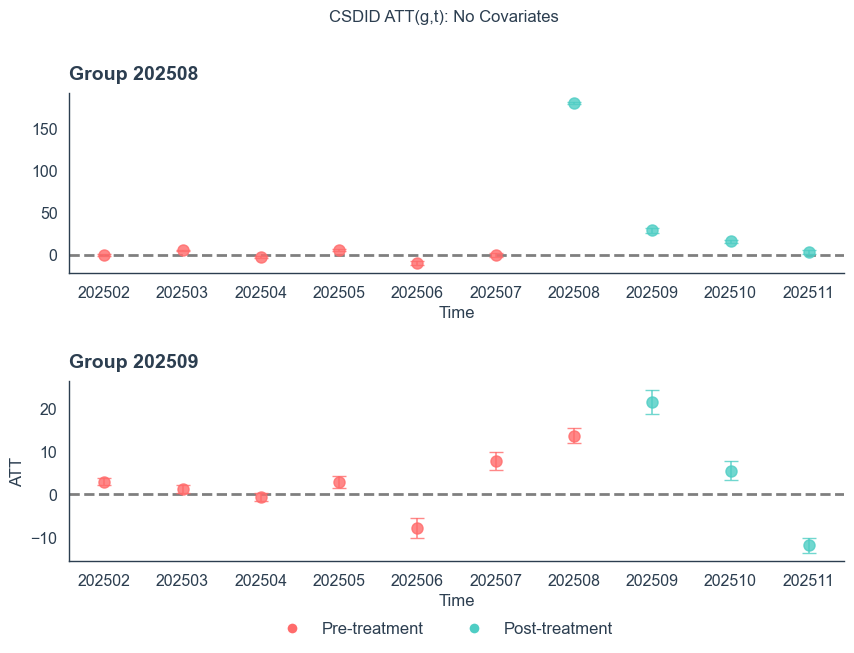

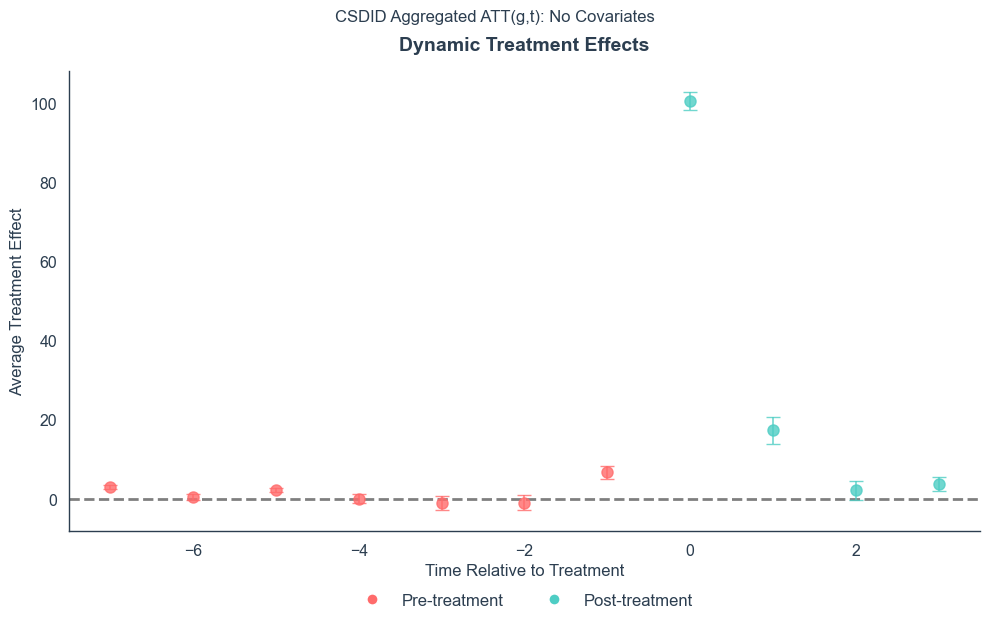

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:125: UserWarning: 49 units were already treated in the first period and will be dropped
  warnings.warn(warning)
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/core/preprocess/builders.py:186: UserWarning: Be aware that there are some small groups in your dataset.
Check groups: 202508.0, 202509.0
  warnings.warn(warning_msg)



Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Simult. Conf. Band]
 202508 202502     0.4326       0.3111  [ -1.4084,   2.2737]  
 202508 202503     4.7006       0.3567  [  2.5898,   6.8114] *
 202508 202504    -1.9376       0.3577  [ -4.0541,   0.1789]  
 202508 202505     6.0069       0.5245  [  2.9033,   9.1105] *
 202508 202506    -8.6044       0.2571  [-10.1258,  -7.0830] *
 202508 202507     0.6166       0.6052  [ -2.9649,   4.1981]  
 202508 202508   177.5865       0.0878  [177.0667, 178.1062] *
 202508 202509    27.9329       0.4623  [ 25.1973,  30.6686] *
 202508 202510    14.9528       0.3000  [ 13.1778,  16.7279] *
 202508 202511     1.6754       0.1048  [  1.0550,   2.2958] *
 202509 202502     2.4606       0.2944  [  0.7184,   4.2027] *
 202509 202503     1.2912       0.2032  [  0.0888,   2.4937] *
 202509 202504    -0.8701       0.3985  [ -3.2284,   1.4882]  
 202509 202505     3.3620       0.6

 Aggregate Treatment Effects (Event Study)

 Call:
   aggte(MP, type='dynamic')

 Overall summary of ATT's based on event-study/dynamic aggregation:

   ATT          Std. Error     [95% Conf. Interval]
      29.8431       0.9741     [27.9339, 31.7524] *


 Dynamic Effects:

    Event time   Estimate   Std. Error   [95% Simult. Conf. Band]
            -7     2.4606       0.2640   [-17.8065, 22.7276]  
            -6     0.8619       0.3341   [-24.7854, 26.5092]  
            -5     1.9153       0.5027   [-36.6789, 40.5094]  
            -4     0.7122       0.7936   [-60.2103, 61.6347]  
            -3    -0.4822       0.8136   [-62.9428, 61.9784]  
            -2    -0.4007       0.5939   [-45.9966, 45.1952]  
            -1     7.0671       1.0083   [-70.3391, 84.4732]  
             0    99.5297       0.9604   [25.7960, 173.2633] *
             1    16.6895       1.6374   [-109.0136, 142.3926]  
             2     1.4780       1.2669   [-95.7841, 98.7401]  
             3     1.6754  

/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/did/plots/core.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


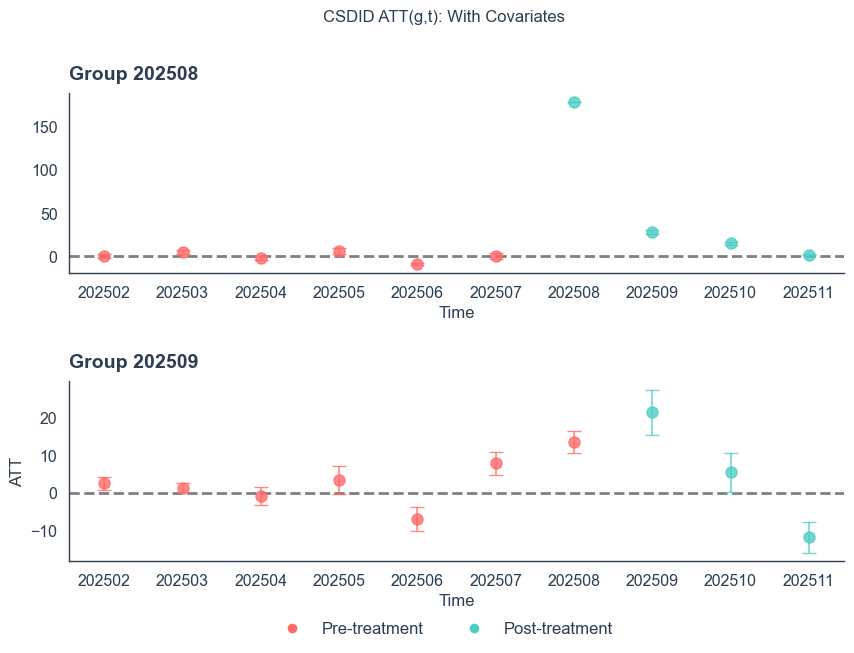

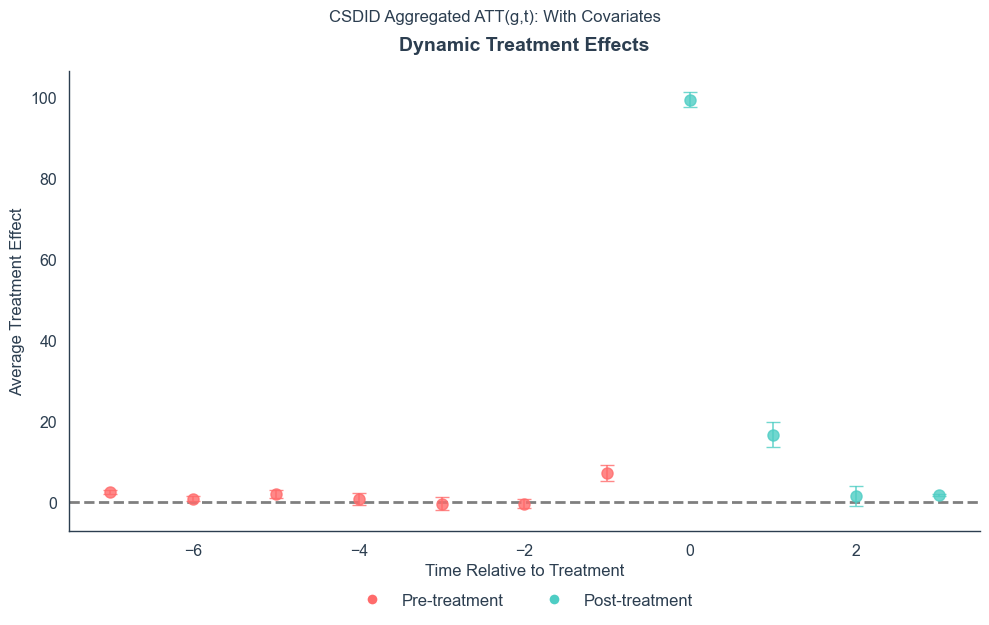

In [10]:
import moderndid as did

# Prepare data for CSDID
df_csdid = df_cov.copy()
df_csdid = df_csdid[df_csdid['date'] >= '2025/01']

# Convert date to datetime and create time_period in YYYYMM format (e.g., 202201 for 2022/01)
df_csdid['date_dt'] = pd.to_datetime(df_csdid['date'], format='%Y/%m')
df_csdid['time_period'] = df_csdid['date_dt'].dt.year * 100 + df_csdid['date_dt'].dt.month

# Create numeric ID
df_csdid['id'] = pd.Categorical(df_csdid['location']).codes

# Create gname column (first treatment period) in YYYYMM format
dc_treat_time = 202508  # 2025/08
il_treat_time = 202509  # 2025/09

df_csdid['first_treat'] = 0
df_csdid.loc[df_csdid['location'] == 'DC', 'first_treat'] = dc_treat_time
df_csdid.loc[df_csdid['location'] == 'IL', 'first_treat'] = il_treat_time

# Model 1: CSDID without covariates
csdid_nocov_attgt = did.att_gt(
    data=df_csdid,
    yname='frequency',
    tname='time_period',
    gname='first_treat',
    idname='id',
    est_method='dr',
    control_group='nevertreated',
    anticipation=0,
    allow_unbalanced_panel=True
)

csdid_nocov_aggte = did.aggte(csdid_nocov_attgt, type='dynamic', min_e=-12, max_e=10)

display(csdid_nocov_attgt)
display(csdid_nocov_aggte)

csdid_plot1 = did.plot_did(csdid_nocov_attgt)
csdid_plot1.suptitle('CSDID ATT(g,t): No Covariates', y=1.02)
csdid_plot1.savefig('./plot/csdid_attgt_nocov.png', bbox_inches='tight')
display(csdid_plot1)


csdid_plot2 = did.plot_did(csdid_nocov_aggte)
csdid_plot2.suptitle('CSDID Aggregated ATT(g,t): No Covariates', y=1.02)
csdid_plot2.savefig('./plot/csdid_aggte_nocov.png', bbox_inches='tight')
display(csdid_plot2)



# Model 2: CSDID with covariates
csdid_cov_attgt = did.att_gt(
    data=df_csdid,
    yname='frequency',
    tname='time_period',
    gname='first_treat',
    idname='id',
    xformla='~ crime_rate',
    est_method='dr',
    control_group='nevertreated',
    anticipation=0,
    allow_unbalanced_panel=True
)

csdid_cov_aggte = did.aggte(csdid_cov_attgt, type='dynamic', min_e=-12, max_e=10)

display(csdid_cov_attgt)
display(csdid_cov_aggte)

csdid_plot3 = did.plot_did(csdid_cov_attgt)
csdid_plot3.suptitle('CSDID ATT(g,t): With Covariates', y=1.02)
csdid_plot3.savefig('./plot/csdid_attgt_cov.png', bbox_inches='tight')
display(csdid_plot3)

csdid_plot4 = did.plot_did(csdid_cov_aggte)
csdid_plot4.suptitle('CSDID Aggregated ATT(g,t): With Covariates', y=1.02)
csdid_plot4.savefig('./plot/csdid_aggte_cov.png', bbox_inches='tight')
display(csdid_plot4)



CSDID No Covariates - HonestDiD Results:
          lb          ub method    delta  Mbar
0  94.551931  106.570518   C-LF  DeltaRM   0.5
1  90.092586  111.029863   C-LF  DeltaRM   1.0
2  85.335506  115.786943   C-LF  DeltaRM   1.5
3  80.565909  120.556540   C-LF  DeltaRM   2.0
4  51.326384  149.796065   C-LF  DeltaRM   5.0
5   2.635961  198.486488   C-LF  DeltaRM  10.0


/var/folders/8g/6g1j06xd7ms8hzz2_27br4vh0000gn/T/ipykernel_41833/3487316659.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sensitivity_plot_nocov.show()
/Users/xingyuanzhao/Documents/projects/psci6356/.venv/lib/python3.13/site-packages/moderndid/didhonest/arp_nuisance.py:225: UserWarning: CI is open at one of the endpoints; CI bounds may not be accurate.
  warnings.warn("CI is open at one of the endpoints; CI bounds may not be accurate.", UserWarning)


CSDID With Covariates - HonestDiD Results:
          lb          ub method    delta  Mbar
0  93.948996  105.110312   C-LF  DeltaRM   0.5
1  89.569322  109.489987   C-LF  DeltaRM   1.0
2  85.009327  114.049981   C-LF  DeltaRM   1.5
3  80.423834  118.635474   C-LF  DeltaRM   2.0
4  52.491427  146.567882   C-LF  DeltaRM   5.0
5   5.642943  193.416365   C-LF  DeltaRM  10.0


/var/folders/8g/6g1j06xd7ms8hzz2_27br4vh0000gn/T/ipykernel_41833/3487316659.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sensitivity_plot_cov.show()


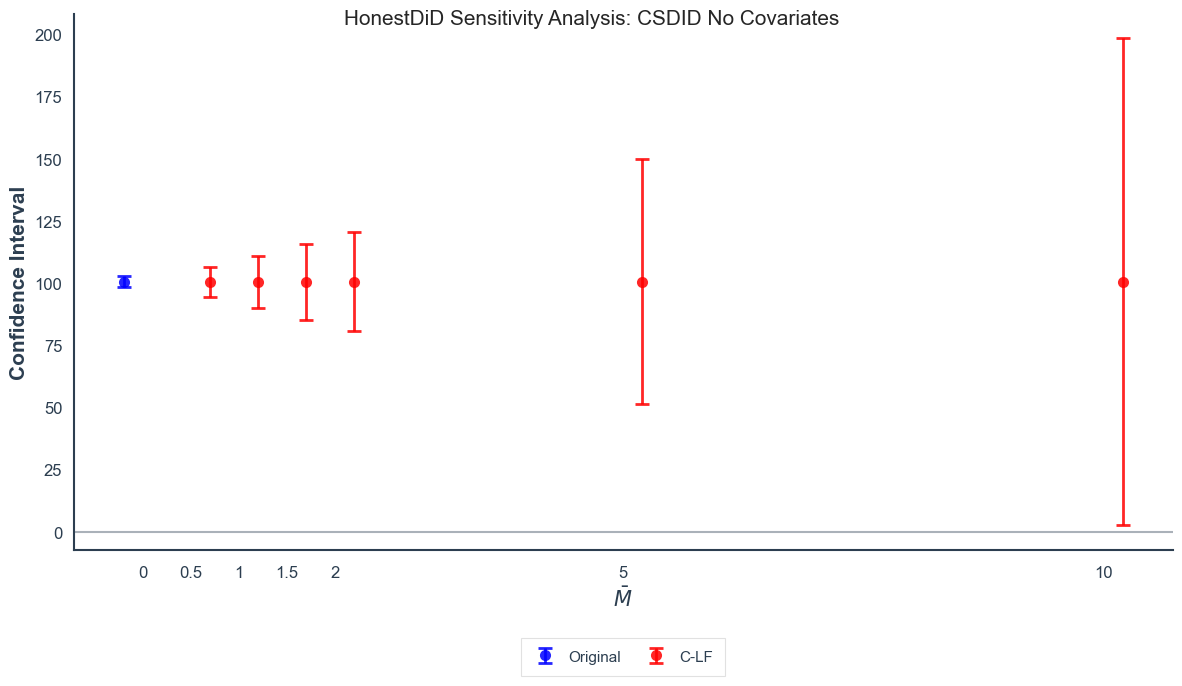

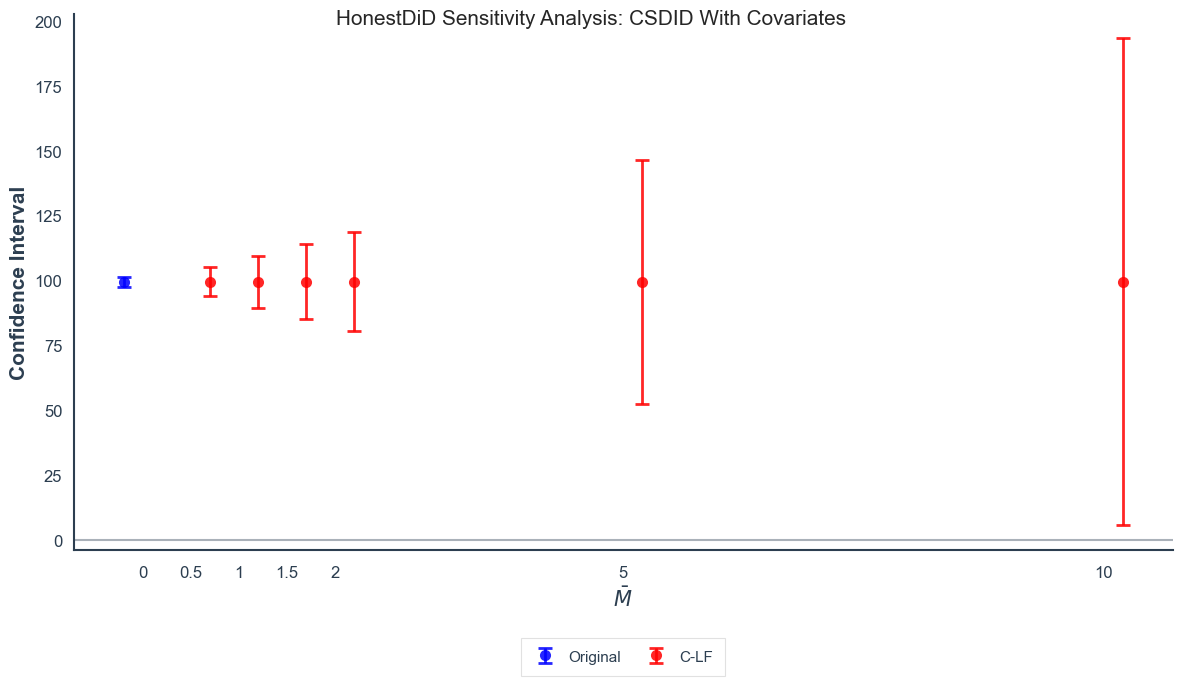

In [11]:
# HonestDiD for CSDID models

# HonestDiD for CSDID without covariates
event_times_nocov = csdid_nocov_aggte.event_times
att_by_event_nocov = csdid_nocov_aggte.att_by_event
se_by_event_nocov = csdid_nocov_aggte.se_by_event

pre_mask_nocov = event_times_nocov < 0
post_mask_nocov = event_times_nocov >= 0

betahat_nocov = np.concatenate([att_by_event_nocov[pre_mask_nocov], att_by_event_nocov[post_mask_nocov]])
se_all_nocov = np.concatenate([se_by_event_nocov[pre_mask_nocov], se_by_event_nocov[post_mask_nocov]])

sigma_nocov = np.diag(se_all_nocov ** 2)

num_pre_periods_nocov = int(np.sum(pre_mask_nocov))
num_post_periods_nocov = int(np.sum(post_mask_nocov))

original_ci_nocov = construct_original_cs(
    betahat=betahat_nocov,
    sigma=sigma_nocov,
    num_pre_periods=num_pre_periods_nocov,
    num_post_periods=num_post_periods_nocov,
    alpha=0.05
)

delta_rm_results_nocov = create_sensitivity_results_rm(
    betahat=betahat_nocov,
    sigma=sigma_nocov,
    num_pre_periods=num_pre_periods_nocov,
    num_post_periods=num_post_periods_nocov,
    m_bar_vec=[0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
    method="C-LF"
)

print("CSDID No Covariates - HonestDiD Results:")
print(delta_rm_results_nocov)

sensitivity_plot_nocov = plot_sensitivity_rm(delta_rm_results_nocov, original_ci_nocov)
sensitivity_plot_nocov.suptitle('HonestDiD Sensitivity Analysis: CSDID No Covariates')
sensitivity_plot_nocov.savefig("./plot/honestdid_csdid_nocov.png", bbox_inches="tight")
sensitivity_plot_nocov.show()

# HonestDiD for CSDID with covariates
event_times_cov = csdid_cov_aggte.event_times
att_by_event_cov = csdid_cov_aggte.att_by_event
se_by_event_cov = csdid_cov_aggte.se_by_event

pre_mask_cov = event_times_cov < 0
post_mask_cov = event_times_cov >= 0

betahat_cov = np.concatenate([att_by_event_cov[pre_mask_cov], att_by_event_cov[post_mask_cov]])
se_all_cov = np.concatenate([se_by_event_cov[pre_mask_cov], se_by_event_cov[post_mask_cov]])

sigma_cov = np.diag(se_all_cov ** 2)

num_pre_periods_cov = int(np.sum(pre_mask_cov))
num_post_periods_cov = int(np.sum(post_mask_cov))

original_ci_cov = construct_original_cs(
    betahat=betahat_cov,
    sigma=sigma_cov,
    num_pre_periods=num_pre_periods_cov,
    num_post_periods=num_post_periods_cov,
    alpha=0.05
)

delta_rm_results_cov = create_sensitivity_results_rm(
    betahat=betahat_cov,
    sigma=sigma_cov,
    num_pre_periods=num_pre_periods_cov,
    num_post_periods=num_post_periods_cov,
    m_bar_vec=[0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
    method="C-LF"
)

print("CSDID With Covariates - HonestDiD Results:")
print(delta_rm_results_cov)

sensitivity_plot_cov = plot_sensitivity_rm(delta_rm_results_cov, original_ci_cov)
sensitivity_plot_cov.suptitle('HonestDiD Sensitivity Analysis: CSDID With Covariates')
sensitivity_plot_cov.savefig("./plot/honestdid_csdid_cov.png", bbox_inches="tight")
sensitivity_plot_cov.show()


In [12]:
display(drdid_dc_nocov)
display(drdid_il_nocov)
display(drdid_dc_cov)
display(drdid_il_cov)

display(csdid_nocov_attgt)
display(csdid_nocov_aggte)
display(csdid_cov_attgt)
display(csdid_cov_aggte)


 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error   t-value  Pr(>|t|)  [95% Conf. Interval]
--------------------------------------------------------------------
ATT   179.3800      0.6864  261.3436    <0.001  [178.0347, 180.7253]

--------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error  t-value  Pr(>|t|)  [95% Conf. Interval]
-------------------------------------------------------------------
ATT    24.4800      3.1487   7.7745    <0.001    [18.3085, 30.6515]

-------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error   t-value  Pr(>|t|)  [95% Conf. Interval]
--------------------------------------------------------------------
ATT   178.3287      0.4073  437.8763    <0.001  [177.5304, 179.1269]

--------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics

 Doubly Robust DiD Estimator (Improved Method)
 Computed from 102 observations and 17 covariates.

      Estimate  Std. Error  t-value  Pr(>|t|)  [95% Conf. Interval]
-------------------------------------------------------------------
ATT    23.9065      2.4702   9.6778    <0.001    [19.0649, 28.7482]

-------------------------------------------------------------------
 Method Details:
   Data structure: Panel data
   Outcome regression: Weighted least squares
   Propensity score: Inverse probability tilting

 Inference:
   Standard errors: Analytical
   Propensity score trimming: 0.995
 Reference: Sant'Anna and Zhao (2020), Journal of Econometrics


Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Simult. Conf. Band]
 202508 202502    -0.0204       0.3369  [ -0.9041,   0.8633]  
 202508 202503     5.2245       0.3376  [  4.3390,   6.1100] *
 202508 202504    -2.6735       0.3385  [ -3.5613,  -1.7857] *
 202508 202505     5.8571       0.5364  [  4.4501,   7.2642] *
 202508 202506    -9.8163       0.9177  [-12.2235,  -7.4092] *
 202508 202507    -0.2245       0.8162  [ -2.3654,   1.9165]  
 202508 202508   179.6531       0.6717  [177.8910, 181.4151] *
 202508 202509    29.1224       1.1695  [ 26.0548,  32.1901] *
 202508 202510    16.1020       0.7712  [ 14.0792,  18.1248] *
 202508 202511     3.7959       0.9282  [  1.3611,   6.2307] *
 202509 202502     2.9796       0.3369  [  2.0959,   3.8633] *
 202509 202503     1.2245       0.3376  [  0.3390,   2.1100] *
 202509 202504    -0.6735       0.3385  [ -1.5613,   0.2143]  
 202509 202505     2.8571       0.5

 Aggregate Treatment Effects (Event Study)

 Call:
   aggte(MP, type='dynamic')

 Overall summary of ATT's based on event-study/dynamic aggregation:

   ATT          Std. Error     [95% Conf. Interval]
      30.9413       1.3241     [28.3462, 33.5364] *


 Dynamic Effects:

    Event time   Estimate   Std. Error   [95% Simult. Conf. Band]
            -7     2.9796       0.3079   [-21.9444, 27.9036]  
            -6     0.6020       0.3873   [-30.7485, 31.9526]  
            -5     2.2755       0.3019   [-22.1595, 26.7105]  
            -4     0.0918       0.6158   [-49.7561, 49.9398]  
            -3    -0.9796       0.9208   [-75.5140, 73.5548]  
            -2    -1.0204       0.9600   [-78.7262, 76.6854]  
            -1     6.7143       0.8155   [-59.2979, 72.7265]  
             0   100.5612       1.1289   [ 9.1780, 191.9444] *
             1    17.2857       1.7144   [-121.4866, 156.0580]  
             2     2.1224       1.1944   [-94.5557, 98.8006]  
             3     3.7959  


Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Simult. Conf. Band]
 202508 202502     0.4326       0.3111  [ -1.4084,   2.2737]  
 202508 202503     4.7006       0.3567  [  2.5898,   6.8114] *
 202508 202504    -1.9376       0.3577  [ -4.0541,   0.1789]  
 202508 202505     6.0069       0.5245  [  2.9033,   9.1105] *
 202508 202506    -8.6044       0.2571  [-10.1258,  -7.0830] *
 202508 202507     0.6166       0.6052  [ -2.9649,   4.1981]  
 202508 202508   177.5865       0.0878  [177.0667, 178.1062] *
 202508 202509    27.9329       0.4623  [ 25.1973,  30.6686] *
 202508 202510    14.9528       0.3000  [ 13.1778,  16.7279] *
 202508 202511     1.6754       0.1048  [  1.0550,   2.2958] *
 202509 202502     2.4606       0.2944  [  0.7184,   4.2027] *
 202509 202503     1.2912       0.2032  [  0.0888,   2.4937] *
 202509 202504    -0.8701       0.3985  [ -3.2284,   1.4882]  
 202509 202505     3.3620       0.6

 Aggregate Treatment Effects (Event Study)

 Call:
   aggte(MP, type='dynamic')

 Overall summary of ATT's based on event-study/dynamic aggregation:

   ATT          Std. Error     [95% Conf. Interval]
      29.8431       0.9741     [27.9339, 31.7524] *


 Dynamic Effects:

    Event time   Estimate   Std. Error   [95% Simult. Conf. Band]
            -7     2.4606       0.2640   [-17.8065, 22.7276]  
            -6     0.8619       0.3341   [-24.7854, 26.5092]  
            -5     1.9153       0.5027   [-36.6789, 40.5094]  
            -4     0.7122       0.7936   [-60.2103, 61.6347]  
            -3    -0.4822       0.8136   [-62.9428, 61.9784]  
            -2    -0.4007       0.5939   [-45.9966, 45.1952]  
            -1     7.0671       1.0083   [-70.3391, 84.4732]  
             0    99.5297       0.9604   [25.7960, 173.2633] *
             1    16.6895       1.6374   [-109.0136, 142.3926]  
             2     1.4780       1.2669   [-95.7841, 98.7401]  
             3     1.6754  

In [13]:
from scipy import stats

results_data = []

for name, result in [
    ('DC (No Covariates)', drdid_dc_nocov),
    ('IL (No Covariates)', drdid_il_nocov),
    ('DC (With Covariates)', drdid_dc_cov),
    ('IL (With Covariates)', drdid_il_cov)
]:
    t_value = result.att / result.se
    p_value = 2 * (1 - stats.t.cdf(abs(t_value), df=100))
    
    results_data.append({
        '': name,
        'drdid ATT': result.att,
        'Std. Error': result.se,
        't-value': t_value,
        'Pr(>|t|)': p_value,
        '[95% Conf. Interval]': f"[{result.lci:.4f}, {result.uci:.4f}] *"
    })

drdid_results_table = pd.DataFrame(results_data)
display(drdid_results_table)

# Export to production-ready HTML with styling
html_string = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
<style>
    body {{
        font-family: 'Times New Roman', Times, serif;
        padding: 20px;
    }}
    table {{
        border-collapse: collapse;
        width: 100%;
        margin: 20px auto;
        font-size: 14px;
    }}
    th {{
        background-color: #f8f9fa;
        border-top: 2px solid #000;
        border-bottom: 2px solid #000;
        padding: 10px;
        text-align: center;
        font-weight: bold;
    }}
    td {{
        border-bottom: 1px solid #ddd;
        padding: 8px;
        text-align: right;
    }}
    td:first-child {{
        text-align: left;
    }}
    tbody tr:last-child td {{
        border-bottom: 2px solid #000;
    }}
</style>
</head>
<body>
{drdid_results_table.to_html(index=False, float_format="%.3f", border=0)}
</body>
</html>
"""
with open('./table/drdid_results_table.html', 'w') as f:
    f.write(html_string)


,,drdid ATT,Std. Error,t-value,Pr(>|t|),[95% Conf. Interval]
0,DC (No Covariates),179.380000,0.686376,261.343640,0.000000e+00,"[178.0347, 180.7253] *"
1,IL (No Covariates),24.480000,3.148745,7.774527,6.918022e-12,"[18.3085, 30.6515] *"
2,DC (With Covariates),178.328657,0.407258,437.876345,0.000000e+00,"[177.5304, 179.1269] *"
3,IL (With Covariates),23.906547,2.470247,9.677794,4.440892e-16,"[19.0649, 28.7482] *"


In [14]:
# Extract overall summary from CSDID aggte results
aggte_sum_data = []

for name, aggte_result in [
    ('CSDID (No Covariates)', csdid_nocov_aggte),
    ('CSDID (With Covariates)', csdid_cov_aggte)
]:
    aggte_sum_data.append({
        'Model': name,
        'ATT': aggte_result.overall_att,
        'Std. Error': aggte_result.overall_se,
        '[95% Conf. Interval]': f"[{aggte_result.overall_att - 1.96 * aggte_result.overall_se:.4f}, {aggte_result.overall_att + 1.96 * aggte_result.overall_se:.4f}] *"
    })

aggte_sum_table = pd.DataFrame(aggte_sum_data)
display(aggte_sum_table)

# Export to production-ready HTML with styling
html_string = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
<style>
    body {{
        font-family: 'Times New Roman', Times, serif;
        padding: 20px;
    }}
    table {{
        border-collapse: collapse;
        width: 100%;
        margin: 20px auto;
        font-size: 14px;
    }}
    th {{
        background-color: #f8f9fa;
        border-top: 2px solid #000;
        border-bottom: 2px solid #000;
        padding: 10px;
        text-align: center;
        font-weight: bold;
    }}
    td {{
        border-bottom: 1px solid #ddd;
        padding: 8px;
        text-align: right;
    }}
    td:first-child {{
        text-align: left;
    }}
    tbody tr:last-child td {{
        border-bottom: 2px solid #000;
    }}
</style>
</head>
<body>
{aggte_sum_table.to_html(index=False, float_format="%.3f", border=0)}
</body>
</html>
"""
with open('./table/aggte_summary_table.html', 'w') as f:
    f.write(html_string)


,Model,ATT,Std. Error,[95% Conf. Interval]
0,CSDID (No Covariates),30.941327,1.324060,"[28.3462, 33.5365] *"
1,CSDID (With Covariates),29.843137,0.974137,"[27.9338, 31.7524] *"


In [15]:
# Extract dynamic effects from CSDID aggte results
dynamic_effects_data = []

# Get event times (same for both models)
event_times = csdid_nocov_aggte.event_times

# Extract data from no covariates model
att_nocov = csdid_nocov_aggte.att_by_event
se_nocov = csdid_nocov_aggte.se_by_event

# Extract data from with covariates model
att_cov = csdid_cov_aggte.att_by_event
se_cov = csdid_cov_aggte.se_by_event

# Build table data
for i, event_time in enumerate(event_times):
    # Calculate 95% confidence bands
    ci_nocov_lower = att_nocov[i] - 1.96 * se_nocov[i]
    ci_nocov_upper = att_nocov[i] + 1.96 * se_nocov[i]
    ci_cov_lower = att_cov[i] - 1.96 * se_cov[i]
    ci_cov_upper = att_cov[i] + 1.96 * se_cov[i]
    
    # Add star for event time 0 only
    star = ' *' if event_time == 0 else ''
    
    dynamic_effects_data.append({
        'event_time': int(event_time),
        'nocov_estimate': att_nocov[i],
        'nocov_se': se_nocov[i],
        'nocov_band': f"[{ci_nocov_lower:.4f}, {ci_nocov_upper:.4f}]{star}",
        'cov_estimate': att_cov[i],
        'cov_se': se_cov[i],
        'cov_band': f"[{ci_cov_lower:.4f}, {ci_cov_upper:.4f}]{star}"
    })

# Create DataFrame
aggte_dynamic_effects_table = pd.DataFrame(dynamic_effects_data)

# Create multi-level columns
aggte_dynamic_effects_table.columns = pd.MultiIndex.from_tuples([
    ('Event time', ''),
    ('CSDID (No Covariates)', 'Estimate'),
    ('CSDID (No Covariates)', 'Std. Error'),
    ('CSDID (No Covariates)', '[95% Simult. Conf. Band]'),
    ('CSDID (With Covariates)', 'Estimate'),
    ('CSDID (With Covariates)', 'Std. Error'),
    ('CSDID (With Covariates)', '[95% Simult. Conf. Band]')
])

display(aggte_dynamic_effects_table)

# Export to production-ready HTML with styling
html_string = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
<style>
    body {{
        font-family: 'Times New Roman', Times, serif;
        padding: 20px;
    }}
    table {{
        border-collapse: collapse;
        width: 100%;
        margin: 20px auto;
        font-size: 14px;
    }}
    th {{
        background-color: #f8f9fa;
        border-top: 2px solid #000;
        border-bottom: 2px solid #000;
        padding: 10px;
        text-align: center;
        font-weight: bold;
    }}
    td {{
        border-bottom: 1px solid #ddd;
        padding: 8px;
        text-align: right;
    }}
    td:first-child {{
        text-align: center;
    }}
    tbody tr:last-child td {{
        border-bottom: 2px solid #000;
    }}
</style>
</head>
<body>
{aggte_dynamic_effects_table.to_html(index=False, float_format="%.3f", border=0)}
</body>
</html>
"""
with open('./table/aggte_dynamic_effects_table.html', 'w') as f:
    f.write(html_string)


Event time CSDID (No Covariates)                                      \
                           Estimate Std. Error [95% Simult. Conf. Band]   
0          -7              2.979592   0.307909         [2.3761, 3.5831]   
1          -6              0.602041   0.387303        [-0.1571, 1.3612]   
2          -5              2.275510   0.301868         [1.6838, 2.8672]   
3          -4              0.091837   0.615818        [-1.1152, 1.2988]   
4          -3             -0.979592   0.920793        [-2.7843, 0.8252]   
5          -2             -1.020408   0.959972        [-2.9020, 0.8611]   
6          -1              6.714286   0.815510         [5.1159, 8.3127]   
7           0            100.561224   1.128942    [98.3485, 102.7740] *   
8           1             17.285714   1.714383       [13.9255, 20.6459]   
9           2              2.122449   1.194355        [-0.2185, 4.4634]   
10          3              3.795918   0.924072         [1.9847, 5.6071]   

   CSDID (With Covariates)                                      
                  Estimate Std. Error [95% Simult. Conf. Band]  
0                 2.460553   0.263994         [1.9431, 2.9780]  
1                 0.861938   0.334077         [0.2071, 1.5167]  
2                 1.915255   0.502719         [0.9299, 2.9006]  
3                 0.712211   0.793564        [-0.8432, 2.2676]  
4                -0.482236   0.813600        [-2.0769, 1.1124]  
5                -0.400717   0.593923        [-1.5648, 0.7634]  
6                 7.067073   1.008277         [5.0909, 9.0433]  
7                99.529654   0.960441    [97.6472, 101.4121] *  
8                16.689502   1.637384       [13.4802, 19.8988]  
9                 1.478012   1.266917        [-1.0051, 3.9612]  
10                1.675382   0.114112         [1.4517, 1.8990]